In this notebook, we'll be implementing the neural ODE on a system where one of the parameters varies with time

 - Original Paper: https://arxiv.org/pdf/1806.07366.pdf
 - Medium article: https://github.com/rtqichen/torchdiffeq
 - PINN vs NeuroODE: https://esciencegroup.com/2020/06/10/notes-on-deep-learning-and-differential-equations/

# Libraries

In [1]:
from torchdiffeq import odeint
import torch
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam
import numpy as np
device = 'cpu'
N = 100

# Forward simulation

In [2]:
N = 100
true_y0 = torch.tensor([[1.0]]).to(device)
t = torch.linspace(0., 30., N).to(device)
true_A = torch.tensor([[1]]).to(device)

class Lambda(nn.Module):
    def forward(self, t, y):
        if t < 20:
            return 0.01*y
        else: 
            return -0.01*y

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

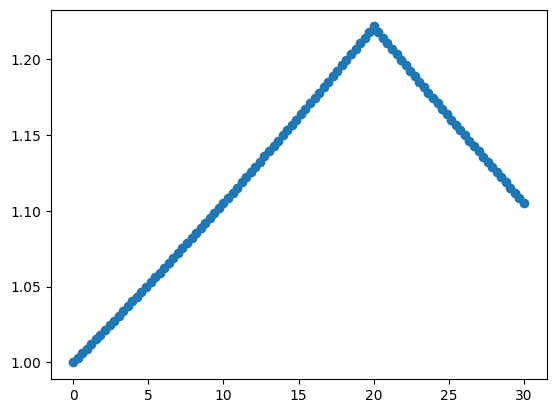

In [3]:
results = true_y.squeeze().numpy()
plt.plot(t,results,'o')

# Inverse solve

In [4]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):     
        try:
            x = torch.stack((y,t.unsqueeze(0).repeat(y.size()[0],y.size()[1],1) ),dim = 2).squeeze()
            return self.net(x)
        except:
            import pdb; pdb.set_trace()
        

In [5]:
def get_batch(t,y_true,batch_time = 10,batch_size = 10):
    d_size = y_true.size()[0]
    start = torch.from_numpy(np.random.choice(np.arange(d_size - batch_time, dtype=np.int64), batch_size, replace=False))# Generate random starting point
    y0_batch = y_true[start]
    t_batch = t[:batch_time]
    y_batch = torch.stack([y_true[start + i] for i in range(10)], dim=0)
    return y_batch, t_batch, y0_batch 

In [6]:
y_batch, t_batch, y0_batch = get_batch(t,true_y)


In [7]:
def optimise(optimiser,func,y0, t,y_true):
    optimiser.zero_grad()
    pred_y = odeint(func, y0, t)
    loss = (pred_y - y_true).pow(2).mean()
    loss.backward()
    optimiser.step()
    return loss

In [8]:
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
full_loss_vector = []
iteration_vector =[]
for i in range(10000):
    y_batch, t_batch,y0_batch = get_batch(t,true_y)
    loss = optimise(optimizer,func,y0_batch, t_batch,y_batch)
    if i % 10==0:
        iteration_vector.append(i)
        full_loss_vector.append(loss.detach().numpy())


RuntimeError: expand(torch.FloatTensor{[10, 10, 1]}, size=[10, 1]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [ ]:
plt.plot(iteration_vector,full_loss_vector)
plt.yscale('log')

In [ ]:
t_predict = torch.linspace(0., 25., 1000).to(device)
with torch.no_grad():
    y_predict = odeint(func, true_y0, t_predict, method='dopri5')
    

In [ ]:
results = true_y.squeeze().numpy()
y_predict_np = y_predict.squeeze().numpy()
plt.plot(t,results)
plt.plot(t_predict,y_predict_np,'go')